# Car Price Prediction

## Machine Learning Regression Algorithm Selection

*Eduardo Solano Jaime*

*0213663*

*ECID*

*Universidad Panamericana campus Guadalajara*

---

### Objective

The following Notebookaims to build a machine learning regression algorithm in order to predict the price of cars based on a the data set [Car Price Prediction(used cars)](https://www.kaggle.com/datasets/vijayaadithyanvg/car-price-predictionused-cars/). Following the checklist provided during class, the proyect will tackle the problem from the begining: including setting the goal of the code, prepare and process the data, feature engineering, odel  building and testing, and final cross validation to determine the optimal method to predict prices.

### Obtain and sample the data

In [289]:
import pandas as pd

dataset = 'car data.csv'
df= pd.read_csv(dataset, sep=',')
names = df.columns
df.sample(3)

,Car_Name,Year,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner
43,dzire,2014,5.50,8.06,45780,Diesel,Dealer,Manual,0
138,Honda CB Hornet 160R,2016,0.60,0.87,15000,Petrol,Individual,Manual,0
174,Honda CB Unicorn,2015,0.38,0.72,38600,Petrol,Individual,Manual,0


### Analysis each feature and its characteristics

In [290]:
print(f'The dataset has a size of {df.shape}')
df.info()

The dataset has a size of (301, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Driven_kms     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Selling_type   301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [291]:
for name in names:
    print(name, df.loc[:, name].unique()[:min(5, len(df.loc[:, name].unique()))], len(df.loc[:, name].unique()))

Car_Name ['ritz' 'sx4' 'ciaz' 'wagon r' 'swift'] 98
Year [2014 2013 2017 2011 2018] 16
Selling_Price [3.35 4.75 7.25 2.85 4.6 ] 156
Present_Price [5.59 9.54 9.85 4.15 6.87] 148
Driven_kms [27000 43000  6900  5200 42450] 206
Fuel_Type ['Petrol' 'Diesel' 'CNG'] 3
Selling_type ['Dealer' 'Individual'] 2
Transmission ['Manual' 'Automatic'] 2
Owner [0 1 3] 3


We have a total of 8 features + target feature before feature engineering. We can clearly see that some of the columns contain categorical and other numerical data, therefore a preprocessing must be made in order to analyze in depths the dataset to determine wether noise is present and extrat statistical information.

In [292]:
names = df.columns
names

Index(['Car_Name', 'Year', 'Selling_Price', 'Present_Price', 'Driven_kms',
       'Fuel_Type', 'Selling_type', 'Transmission', 'Owner'],
      dtype='object')

Now, before using Pipelines to transform further the date we split it in a 80-20 ratio between test and train. We wont see the test set until the end of the analysis

In [293]:
from sklearn.model_selection import train_test_split

df.columns = [x.replace('_', '') for x in df.columns]
names = df.columns
target = 'PresentPrice'
y = df.loc[:, target]
X = df.loc[:, [x for x in df.columns.values if x!=target]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.sample(3)

,CarName,Year,SellingPrice,Drivenkms,FuelType,Sellingtype,Transmission,Owner
109,Royal Enfield Classic 350,2017,1.2,11000,Petrol,Individual,Manual,0
238,verna,2013,4.8,60241,Petrol,Dealer,Manual,0
123,Royal Enfield Classic 350,2013,1.0,46500,Petrol,Individual,Manual,0


### Transform data

First, let us find outliers in the *target* and remove them

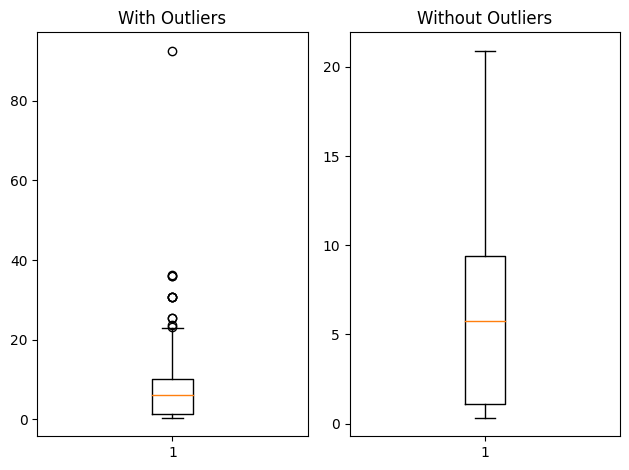

In [294]:
import matplotlib.pyplot as plt
import seaborn as sea

X_train[target] = y_train

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.boxplot(X_train[target])
ax1.set_title('With Outliers')

while True:
    q1 = X_train[target].quantile(0.25)
    q3 = X_train[target].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    if(X_train[(X_train[target] < lower_bound) | (X_train[target] > upper_bound)].empty):
        break
    X_train = X_train[(X_train[target] >= lower_bound) & (X_train[target] <= upper_bound)]

ax2.boxplot(X_train[target])
ax2.set_title('Without Outliers')

plt.tight_layout()
plt.show()

y_train = X_train[target]
X_train = X_train.drop(target, axis=1)

For **Categorical data** specific transformations are to be made:
 - Nominal variables
   - *CarName* - LabelEncoder (although I suspect the car name is going to have no correlation with the price)
   - *FuelType* LabelEncoder or OneHotEncoder
   - *Sellingtype* and *Transmission* simple replacement

For **Numerical data** a simple StandardScaler is going to be used since there are no missing values

In [295]:
# Numerical data
numeric = ['Year', 'SellingPrice', 'Drivenkms']

# Binary cata
binary = ['Sellingtype', 'Transmission']

# Easy binary replacements for binary columns
X_train[binary] = X_train.loc[:, binary].replace({'Dealer':0,  'Individual':1, 'Manual':0, 'Automatic':1})
X_test[binary] = X_test.loc[:, binary].replace({'Dealer':0,  'Individual':1, 'Manual':0, 'Automatic':1})

X_train.sample(3)

,CarName,Year,SellingPrice,Drivenkms,FuelType,Sellingtype,Transmission,Owner
174,Honda CB Unicorn,2015,0.38,38600,Petrol,1,0,0
274,brio,2014,5.30,16500,Petrol,0,0,0
287,amaze,2015,5.75,44000,Petrol,0,1,0


### Extra features

I theorize that the relationship between the year the car was sold and how many kilometers weights heavily. I am adding an extra feature to relate them

In [296]:
X_train['WellKept'] = X_train.loc[:, 'Drivenkms'] * X_train.loc[:, 'Year'] # type: ignore
X_test['WellKept'] = X_test.loc[:, 'Drivenkms'] * X_test.loc[:, 'Year'] # type: ignore
numeric = ['Year', 'SellingPrice', 'Drivenkms', 'WellKept']
names = X_train.columns

In [297]:
# pip install category-encoders

In [298]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from category_encoders import BinaryEncoder, OneHotEncoder

# dummy = FunctionTransformer(lambda x: pd.get_dummies(x, drop_first=True), validate=False)

ct = ColumnTransformer(transformers=
                       [('imputer', SimpleImputer(), numeric),
                        ('numeric', StandardScaler(), numeric),
                        ('cars', BinaryEncoder(), ['CarName']),
                        ('fuel', OrdinalEncoder(), ['FuelType'])],
                       remainder='passthrough')

ct.fit(X_train)

X_train_fit = ct.transform(X_train)
columns = numeric + [x for x in list(ct.get_feature_names_out()[4:-4])] + ['FuelType', 'Sellingtype', 'Transmission', 'Owner']
X_train_fit = pd.DataFrame(X_train_fit, columns=columns)
X_train_fit = X_train_fit.drop(numeric, axis=1)

X_test_fit = ct.transform(X_test)
columns = numeric + [x for x in list(ct.get_feature_names_out()[4:-4])] + ['FuelType', 'Sellingtype', 'Transmission', 'Owner']
X_test_fit = pd.DataFrame(X_test_fit, columns=columns)
X_test_fit.drop(numeric, axis=1)

X_train_fit.sample(5)

,numeric__Year,numeric__SellingPrice,numeric__Drivenkms,numeric__WellKept,cars__CarName_0,cars__CarName_1,cars__CarName_2,cars__CarName_3,cars__CarName_4,cars__CarName_5,cars__CarName_6,FuelType,Sellingtype,Transmission,Owner
145,0.853951,-0.806506,-0.437926,-0.437951,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0
4,-2.398738,-1.107545,0.320762,0.318394,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,1.0,0.0,1.0
139,0.131131,0.999731,0.296288,0.298028,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
15,0.131131,0.773951,0.224776,0.226301,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0
164,0.853951,-1.032285,-0.866217,-0.867954,1.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,1.0,1.0,0.0


### Correlation Matrix

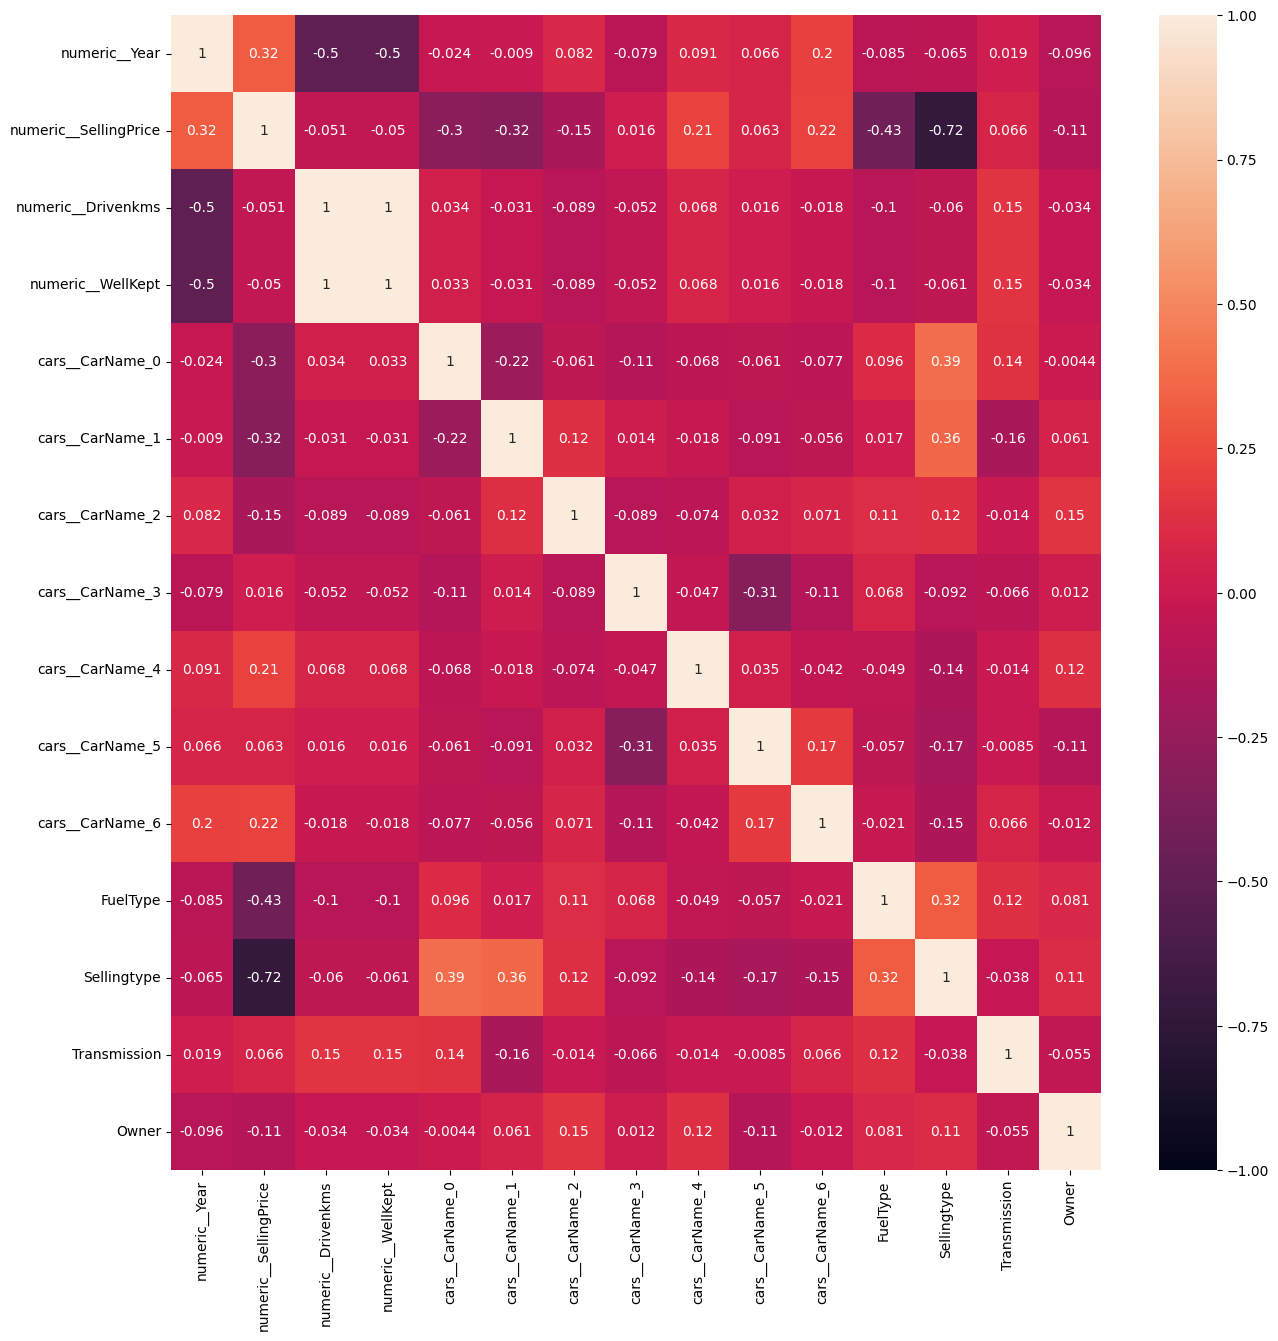

In [299]:
correlation = X_train_fit.corr()
fig1 = plt.figure(figsize=(15,15))
ax = sea.heatmap(correlation, annot=True, vmin=-1, vmax=1)
plt.show()

There are some positively correlated features

Now, feature engineering is needed to remove those higly correlated features

In [300]:
import numpy as np

corr = X_train_fit.corr().abs() # type: ignore
up = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [column for column in up.columns if any(up[column] > 0.7)]
X_train_fit.drop(to_drop, axis=1, inplace=True) # type: ignore
X_test_fit.drop(to_drop, axis=1, inplace=True) # type: ignore
X_train_fit.sample(3)

,numeric__Year,numeric__SellingPrice,numeric__Drivenkms,cars__CarName_0,cars__CarName_1,cars__CarName_2,cars__CarName_3,cars__CarName_4,cars__CarName_5,cars__CarName_6,FuelType,Transmission,Owner
74,1.215361,-0.926922,-0.805033,0.0,1.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0
4,-2.398738,-1.107545,0.320762,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,1.0
95,0.853951,-0.851662,-0.738953,0.0,1.0,1.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0


### Shortlist Promising Models

In [301]:
# Get the models

from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge
import xgboost as xgb

models = [LinearRegression(), PolynomialFeatures(include_bias=False), Ridge(), Lasso(), DecisionTreeRegressor(),
          RandomForestRegressor(), SGDRegressor(), KNeighborsRegressor(), BayesianRidge()]

xgb.set_config(verbosity=0)

In [302]:
first_scores = []
for model in models:
    score = 0
    if str(model)=='PolynomialFeatures(include_bias=False)':
        model = LinearRegression()
        poly_features = PolynomialFeatures()
        X_poly = poly_features.fit_transform(X_train_fit)
        model.fit(X_poly, y_train)
        score = model.score(X_poly, y_train)
        model = PolynomialFeatures()
    else:
        model.fit(X_train_fit, y_train)
        score = model.score(X_train_fit, y_train)
        first_scores.append(score)
    print(f"Score of {score:.5f} was achieved with {model}")

Score of 0.83993 was achieved with LinearRegression()
Score of 0.97012 was achieved with PolynomialFeatures()
Score of 0.83985 was achieved with Ridge()
Score of 0.70201 was achieved with Lasso()
Score of 1.00000 was achieved with DecisionTreeRegressor()
Score of 0.98790 was achieved with RandomForestRegressor()
Score of 0.83248 was achieved with SGDRegressor()
Score of 0.89627 was achieved with KNeighborsRegressor()
Score of 0.83965 was achieved with BayesianRidge()


Before jumping to any conclusions about the performance of the models, I want to try a different feature engineering in which the *CarName* and *FuelType* columns go through a OneHotEncoder
So we change the Transformers and perform everything again

In [303]:
ct2 = ColumnTransformer(transformers=
                       [('imputer', SimpleImputer(), numeric),
                        ('numeric', StandardScaler(), numeric),
                        ('category', OneHotEncoder(), ['CarName', 'FuelType'])],
                       remainder='passthrough')

X_train_fit2 = ct2.fit_transform(X_train)
columns2 = numeric + [x for x in list(ct2.get_feature_names_out()[4:-4])] + ['FuelType', 'Sellingtype', 'Transmission', 'Owner']
X_train_fit2 = pd.DataFrame(X_train_fit2, columns=columns2)
X_train_fit2 = X_train_fit2.drop(numeric, axis=1)

X_test_fit2 = ct2.transform(X_test)
columns2 = numeric + [x for x in list(ct2.get_feature_names_out()[4:-4])] + ['FuelType', 'Sellingtype', 'Transmission', 'Owner']
X_test_fit2 = pd.DataFrame(X_test_fit2, columns=columns2)
X_test_fit2 = X_test_fit2.drop(numeric, axis=1)

corr = X_train_fit2.corr().abs() # type: ignore
up = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop2 = [column for column in up.columns if any(up[column] > 0.7)]
X_train_fit2.drop(to_drop2, axis=1, inplace=True) # type: ignore

for model, old_score in zip(models, first_scores):
    if str(model)=='PolynomialFeatures(include_bias=False)':
        model = LinearRegression()
        poly_features = PolynomialFeatures(degree=2)
        X_poly = poly_features.fit_transform(X_train_fit2)
        model.fit(X_poly, y_train)
        score = model.score(X_poly, y_train)
        model = PolynomialFeatures()
    else:
        model.fit(X_train_fit2, y_train)
        score = model.score(X_train_fit2, y_train)
    print(f"{model} score: {score:.5f}")
    if old_score-score < 0:
        print(f"    Improvement of {abs(old_score-score):.5f}")
    else:
        print(f"    Setback of {(old_score-score):.5f}")

LinearRegression() score: 0.97586
    Improvement of 0.13593
PolynomialFeatures() score: 0.99428
    Improvement of 0.15443
Ridge() score: 0.94231
    Improvement of 0.24030
Lasso() score: 0.70201
    Setback of 0.29799
DecisionTreeRegressor() score: 1.00000
    Improvement of 0.01210
RandomForestRegressor() score: 0.99207
    Improvement of 0.15959
SGDRegressor() score: 0.91466
    Improvement of 0.01839
KNeighborsRegressor() score: 0.92450
    Improvement of 0.08485


Only the *Lasso*  model performs worse with the new transformers, therefore the change helps the data prediction. From now on, the new ColumnTransformer is used.

Let us redefine the column transformer

In [304]:
ct = ColumnTransformer(transformers=
                        [('imputer', SimpleImputer(), numeric),
                        ('numeric', StandardScaler(), numeric),
                        ('category', OneHotEncoder(), ['CarName', 'FuelType'])],
                        remainder='passthrough')

X_train_fit = X_train_fit2
X_test_fit = X_train_fit2

Now we can pick our top 3 candidate, and according to their scores:
1. **DecisionTreeRegressor()**
2. **RandomForest()**
3. **PolynomialFeatures()()**
4. **BayesianRidge()**

Identify the most and least important features of each model.

In [305]:
tree = DecisionTreeRegressor()
tree_m = tree.fit(X_train_fit, y_train)

poly_m = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_m.fit_transform(X_train_fit)
poly = LinearRegression().fit(X_poly, y_train)

bayesian = BayesianRidge()
bayesian_m = bayesian.fit(X_train_fit, y_train) # type: ignore

print('Most important:')
print(f"Tree: {[list(X_train_fit.columns)[i] for i in np.argsort(tree_m.feature_importances_)[::-1][:5]]}") # type: ignore
print(f"Polynomial: {[poly_m.get_feature_names_out()[i] for i in np.argsort(poly.coef_)[::-1][:5]]}")
print(f"Bayesian: {[list(X_train_fit.columns)[i] for i in np.argsort(bayesian_m.feature_names_in_)[::-1][:5]]}") # type: ignore
print()
print('Least importance')
print(f"Tree: {[list(X_train_fit.columns)[i] for i in np.argsort(tree_m.feature_importances_)[:5]]}") # type: ignore
print(f"Polynomial: {[poly_m.get_feature_names_out()[i] for i in np.argsort(poly.coef_)[:5]]}")
print(f"Bayesian: {[list(X_train_fit.columns)[i] for i in np.argsort(bayesian_m.feature_names_in_)[:5]]}") # type: ignore

Most important:
Tree: ['numeric__SellingPrice', 'category__CarName_12', 'numeric__Year', 'numeric__Drivenkms', 'category__CarName_7']
Polynomial: ['category__CarName_21', 'category__CarName_14', 'category__CarName_4', 'category__CarName_3', 'category__CarName_2^2']
Bayesian: ['numeric__Year', 'numeric__SellingPrice', 'numeric__Drivenkms', 'category__FuelType_2', 'category__FuelType_1']

Least importance
Tree: ['Owner', 'category__CarName_75', 'category__CarName_28', 'category__CarName_29', 'category__CarName_73']
Polynomial: ['category__CarName_5', 'category__CarName_10', 'category__CarName_4^2', 'category__CarName_2', 'category__CarName_29']
Bayesian: ['Owner', 'Transmission', 'category__CarName_1', 'category__CarName_10', 'category__CarName_11']


### Fine-Tune the models

In [306]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedKFold

repeatedkfold = RepeatedKFold(n_splits=5, n_repeats=25)

param_grids = [
    {'criterion': ['absolute_error', 'squared_error', 'friedman_mse'],  # DecisionTree
    'max_depth': [None, 5, 10, 20, 30, 40, 50],
    'min_samples_split': [i for i in range(2, 11)],
    'min_samples_leaf': [1, 2, 4],},
    {'polynomialfeatures__degree': [1, 2, 3],                           # Polynomial Regression
     'polynomialfeatures__include_bias':[True, False]},
    {'alpha_1': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2],                         # Bayesian Ridge
    'alpha_2': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
    'lambda_1': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
    'lambda_2': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]}
    ]

regressors = [tree, poly, bayesian]
best_estimator = {}
for regressor, param_grid in zip(regressors[::-1], param_grids[::-1]):
    if str(regressor) == 'LinearRegression()':
        pipeline = Pipeline([
                            ('polynomialfeatures', PolynomialFeatures()),
                            ('linearregression', LinearRegression())
                        ])
        grid_search = GridSearchCV(pipeline, param_grid, cv=5)
        grid_search.fit(X_train_fit, y_train)
    else:
        grid_search = GridSearchCV(regressor, param_grid, cv=5)
        grid_search.fit(X_train_fit, y_train)
    print(f"{regressor}: {grid_search.best_estimator_}")
    print(f"Best params: {grid_search.best_params_}")
    print(f"Score: {grid_search.best_score_*100:,.2f}%", '\n')
    best_estimator[str(regressor)] = grid_search.best_estimator_


BayesianRidge(): BayesianRidge(alpha_1=0.01, lambda_2=0.01)
Best params: {'alpha_1': 0.01, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 0.01}
Score: 85.49% 



KeyboardInterrupt: 

Now that we have determined the best model is **DecisionTreeRegressor**, let´s try a final change before cross validation: remove the subsets of the least 5 important features and see what happens

In [ ]:
from itertools import permutations

tree = best_estimator['DecisionTreeRegressor()']
tree_m = tree.fit(X_train_fit, y_train)

lest_important = [list(X_train_fit.columns)[i] for i in np.argsort(tree_m.feature_importances_)[:5]]
perm = [list(permutations(lest_important, i))for i in range(1, len(lest_important)+1)]
subsets = [list(x) for y in perm  for x in y]


In [ ]:
names_fit = X_test_fit.columns
best_score = 0
best_subset = []
best_aux = []
for subset in subsets:
  aux = names_fit.difference(subset)
  temp = X_train_fit.loc[:, aux]
  tree.fit(temp, y_train)
  score = tree.score(temp, y_train)
  if score>best_score:
      best_score = score
      best_subset = subset
      best_aux = aux

print(f"By removing {best_subset} we get the optimal score of {best_score}")
X_train_fit_fout = X_train_fit.loc[:, best_aux]
X_test_fit_fout = X_test_fit.loc[:, best_aux]

KeyError: "['Drivenkms', 'SellingPrice', 'WellKept', 'Year'] not in index"

In [ ]:
tree = best_estimator['DecisionTreeRegressor()']
tree_m = tree.fit(X_train_fit_fout, y_train)

## Cross Validation

In [ ]:
X = pd.concat([X_train_fit_fout, X_test_fit_fout])
y = pd.concat([y_train, y_test])

### KFolding

In [ ]:
from sklearn.model_selection import KFold, cross_val_score

num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True)
result = cross_val_score(tree, X, y, cv=kfold)
print(f"La media de los {len(result)} folds es {result.mean():,.3f} con std de {result.std():,.3f}")

La media de los 10 folds es 0.846 con std de 0.098


### Train-test split

In [ ]:
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
result = tree.score(X_test, y_test)
print(f"Score: {result:,.3f}")

Score: 0.990


### Repeated KFolding

In [ ]:
from sklearn.model_selection import RepeatedKFold

num_folds = 10
num_repeated = 20
repeatedkfold = RepeatedKFold(n_splits=num_folds, n_repeats=num_repeated)
result = cross_val_score(tree, X, y, cv=repeatedkfold)
print(f"Accuracy: {result.mean()*100:,.2f}%, std {result.std():,.2f}")

Accuracy: 78.79%, std 0.18


In [ ]:
def DataTransform(data: list) -> pd.DataFrame:
  data = [{name:x for name, x in zip([i for i in names if i!=target or i!='Wellkept'], data)}]
  X = pd.DataFrame(data)
  X[binary] = X.loc[:, binary].replace({'Dealer':0,  'Individual':1, 'Manual':0, 'Automatic':1})
  X['WellKept'] = X.loc[:, 'Drivenkms'] * X.loc[:, 'Year']
  X_fit = ct.transform(X)
  X_fit = pd.DataFrame(X_fit, columns=columns)
  X_fit.drop(to_drop, axis=1, inplace=True)
  X_fit.drop(best_subset, axis=1, inplace=True)
  return X_fit

In [ ]:
tocayo = ['raptor', 2022, 1.038, 600000, 'Petrol', 'Individual', 'Automatic', 1]
tocayo = DataTransform(tocayo)
display(tocayo)
print(tocayo.columns)
tree.predict(tocayo)

,Year,SellingPrice,Drivenkms,cars__CarName_0,cars__CarName_2,cars__CarName_3,cars__CarName_4,cars__CarName_5,cars__CarName_6,FuelType,Owner
0,2022.0,1.038,600000.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0


Index(['Year', 'SellingPrice', 'Drivenkms', 'cars__CarName_0',
       'cars__CarName_2', 'cars__CarName_3', 'cars__CarName_4',
       'cars__CarName_5', 'cars__CarName_6', 'FuelType', 'Owner'],
      dtype='object')


ValueError: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.
